In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from Histogramme import Histogramme
from KernelDensity import KernelDensity

In [3]:
plt.ion()
parismap = mpimg.imread('data/paris-48.806-2.23--48.916-2.48.jpg')

## coordonnees GPS de la carte
xmin,xmax = 2.23,2.48   ## coord_x min et max
ymin,ymax = 48.806,48.916 ## coord_y min et max

def show_map(save=False):
    plt.imshow(parismap,extent=[xmin,xmax,ymin,ymax],aspect=1.5)
    ## extent pour controler l'echelle du plan

Liste des types de POI atm, furniture_store, night_club, convenience_store, lodging, restaurant, clothing_store, cafe, home_goods_store, bakery, laundry, bar


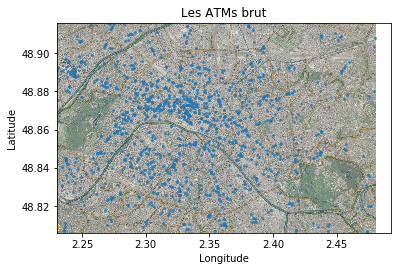

In [4]:
poifile = "data/poi-paris.pkl"
poidata = pickle.load(open(poifile,"rb"))
## liste des types de point of interest (poi)
print("Liste des types de POI" , ", ".join(poidata.keys()))

## Choix d'un poi
typepoi = "atm"

## Creation de la matrice des coordonnees des POI
geo_mat = np.zeros((len(poidata[typepoi]),2))
for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0]

## Affichage brut des poi
show_map()
## alpha permet de regler la transparence, s la taille
plt.scatter(geo_mat[:,1],geo_mat[:,0],alpha=0.8,s=3)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Les ATMs brut")
plt.savefig('../compte_rendu/TME1_6/images/tme2/atms_brut.png')

Visualiser le carte, histogramme calculé par matplotlib et le histogramme calculé par classe Histogramme.
On fait se varier le nombre des bins dans l'histogramme.

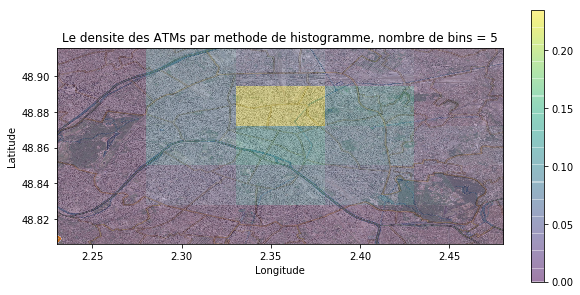

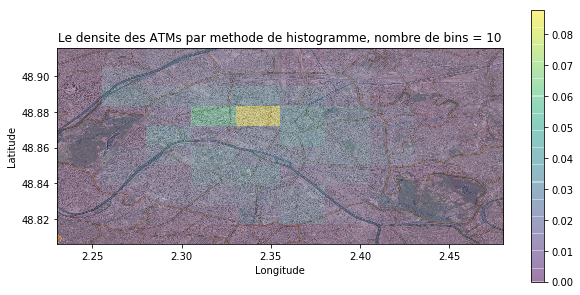

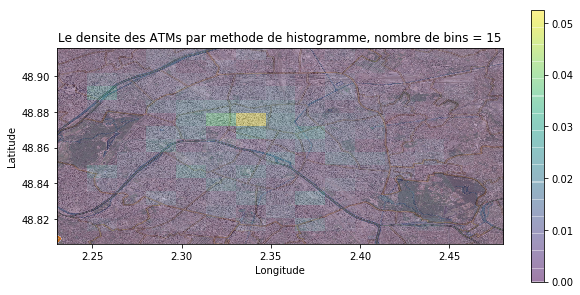

In [14]:
for steps in [5,10,15]:
    # discretisation pour l'affichage des modeles d'estimation de densite
    xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
    grid = np.c_[xx.ravel(),yy.ravel()]

    # A remplacer par res = monModele.predict(grid).reshape(steps,steps)
    #hist2d = np.histogram2d(geo_mat[:,0],geo_mat[:,1], normed=1)
    #res = np.random.random((steps,steps))
    monModele = Histogramme(geo_mat)
    res = monModele.predict(grid).reshape(steps,steps)
    plt.figure(num=None, figsize=(10,5))
    show_map()
    #plt.figure(num=None, figsize=(6,4))
    #plt.hist2d(geo_mat[:,1],geo_mat[:,0])
    
    plt.imshow(res,extent=[xmin,xmax,ymin,ymax],interpolation="none",alpha=0.3,origin = "lower")
    plt.colorbar()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Le densite des ATMs par methode de histogramme, nombre de bins = " + str(steps))
    plt.savefig('../compte_rendu/TME1_6/images/tme2/atms_histo_'+str(steps)+'.png')

On peut voir chaque fois bien, que le densité maximum (des ATMs) est dans 9iéme arrondissement. Par contre c'est pas trés visible dans les endroits ou dénsité est moins fort.

## Densité par noyaux

Comme la methode de histogramme ne permet pas visualiser les atms, si on discretise avec 15 etapes, je vais fixer le variable steps à 15 pour l'éstimation par noyau. L'éstimation par noyau a une variable h qui est taille de lissage. On va varier d'abord h.

### Parzen comme fonction de Noyau

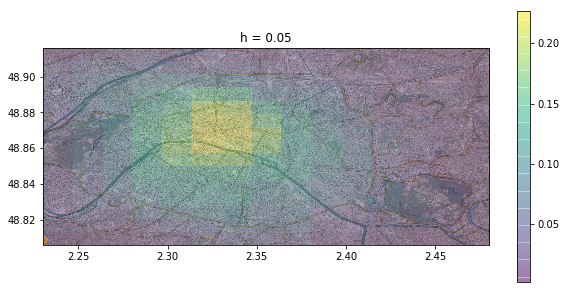

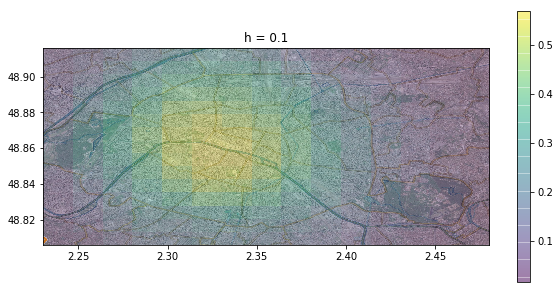

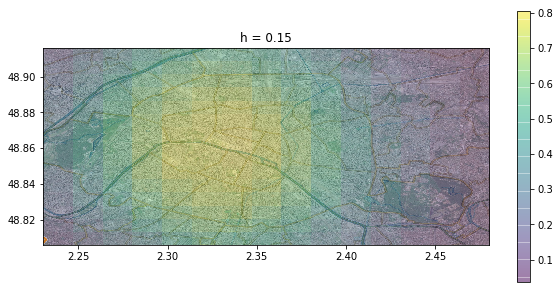

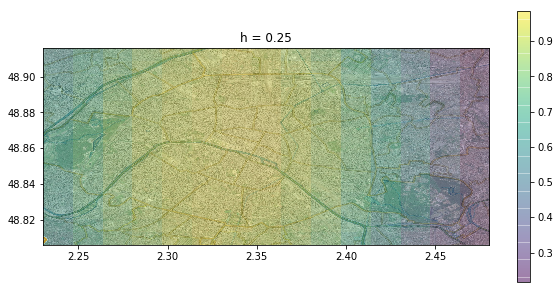

In [5]:
steps = 15
# discretisation pour l'affichage des modeles d'estimation de densite
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[yy.ravel(),xx.ravel()]

model_noyau = KernelDensity(geo_mat, 'parzen')

for i,h in enumerate([0.05, 0.1, 0.15, 0.25]):
    densite_noyau = model_noyau.predict(grid,h).reshape(steps,steps)
    plt.figure(num=None, figsize=(10,5))
    plt.title("h = " + str(h))
    show_map()
    plt.imshow(densite_noyau,extent=[xmin,xmax,ymin,ymax],interpolation="none",alpha=0.3,origin = "lower")
    plt.colorbar()
    plt.savefig('../compte_rendu/TME1_6/images/tme2/atms_parzen_'+str(i)+'.png')

Dans ce cas, si h >= 0.25, l'éstimation est "oversmoothed". h = 0.15 l'air le plus optimal, car il tiens en compte les points partout dans Paris, mais le densité est egalément visible.

### Gauss comme fonction de Noyau

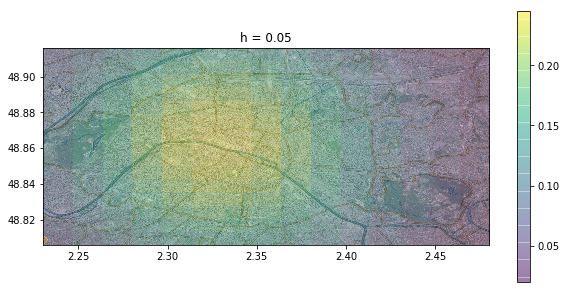

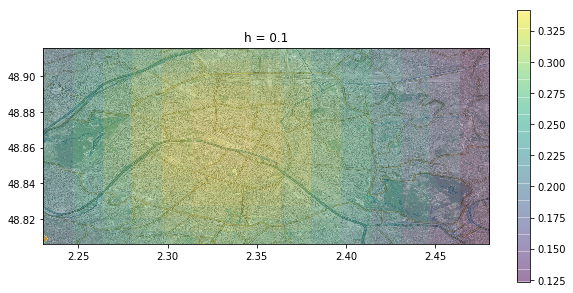

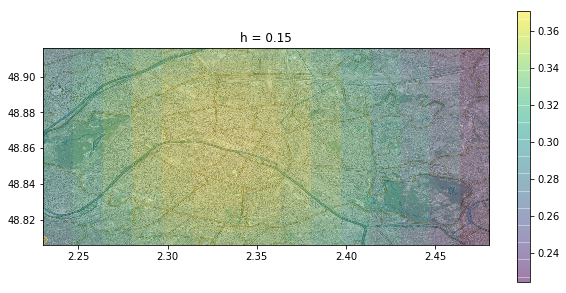

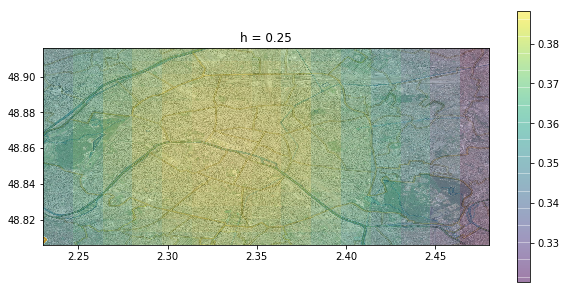

In [7]:
steps = 15
# discretisation pour l'affichage des modeles d'estimation de densite
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[yy.ravel(),xx.ravel()]

model_noyau = KernelDensity(geo_mat, 'gauss')

for i,h in enumerate([0.05, 0.1, 0.15, 0.25]):
    densite_noyau = model_noyau.predict(grid,h).reshape(steps,steps)
    plt.figure(num=None, figsize=(10,5))
    plt.title("h = " + str(h))
    show_map()
    plt.imshow(densite_noyau,extent=[xmin,xmax,ymin,ymax],interpolation="none",alpha=0.3,origin = "lower")
    plt.colorbar()
    plt.savefig('../compte_rendu/TME1_6/images/tme2/atms_gauss_'+str(i)+'.png')

Avec le gaussien, le meilleur paramatre de lissage est peut être 0.05.

#### Comment choisir de manière automatique les meilleurs paramètres ?

C'est possible de deduire automatiquement le meilleur parametre h. En calculant MISE (Mean integrated squared error), on peut deduire l'optimal h. Par exemple, pour lissage gaussian l'optimal h sera ~1.06 * ecart-type * n ^ 1/5.

https://en.wikipedia.org/wiki/Kernel_density_estimation#Bandwidth_selection
[Very fast optimal bandwidth selection for univariate
kernel density estimation, Raykar et al](http://www.umiacs.umd.edu/labs/cvl/pirl/vikas/publications/CS-TR-4774.pdf)

Calculons l'optimal h pour les données.

In [9]:
def calcul_gauss_h_optim(data):
    norms = np.array([np.linalg.norm(g) for g in data])
    ecart = norms.std()
    n = len(data)
    return 1.06 * ecart * n ** 0.2

h_optimal = calcul_gauss_h_optim(geo_mat)
print("h optimal = ",h_optimal)

h optimal =  0.110482310867


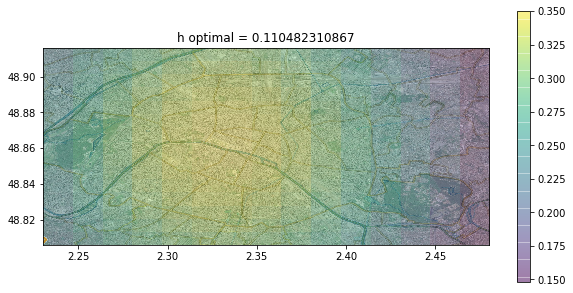

In [10]:
steps = 15
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[yy.ravel(),xx.ravel()]

model_noyau = KernelDensity(geo_mat, 'gauss')

densite_noyau = model_noyau.predict(grid,h_optimal).reshape(steps,steps)
plt.figure(num=None, figsize=(10,5))
plt.title("h optimal = " + str(h_optimal))
show_map()
plt.imshow(densite_noyau,extent=[xmin,xmax,ymin,ymax],interpolation="none",alpha=0.3,origin = "lower")
plt.colorbar()
plt.savefig('../compte_rendu/TME1_6/images/tme2/atms_gauss_optimal.png')

## Differentes POIs

In [5]:
poifile = "data/poi-paris.pkl"
poidata = pickle.load(open(poifile,"rb"))
## liste des types de point of interest (poi)
print("Liste des types de POI" , ", ".join(poidata.keys()))

def get_poi_geo(data,poi):
    geo = np.zeros((len(data[poi]),2))
    for i,(k,v) in enumerate(data[poi].items()):
        geo[i,:]=v[0]
    return geo

pois = [("bar",get_poi_geo(poidata,"bar")),
        ("night_club",get_poi_geo(poidata,"night_club")),
        ("laundry",get_poi_geo(poidata,"laundry")),
        ("cafe",get_poi_geo(poidata,"cafe"))]

Liste des types de POI restaurant, clothing_store, cafe, bakery, convenience_store, night_club, bar, laundry, lodging, atm, furniture_store, home_goods_store


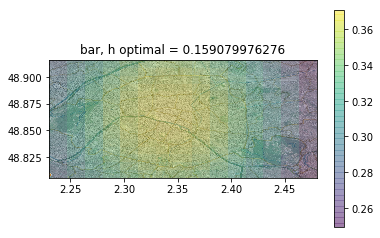

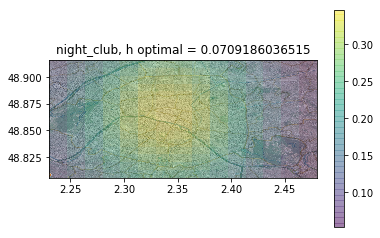

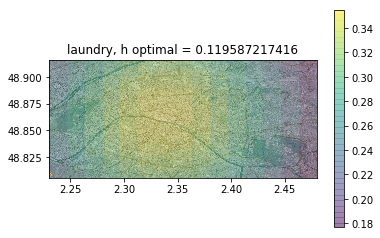

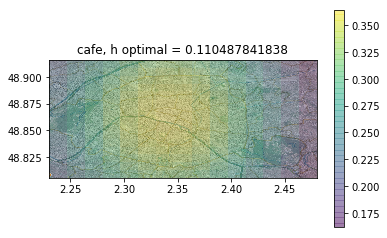

In [12]:
steps = 15
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[yy.ravel(),xx.ravel()]

for poi in pois:
    model_noyau = KernelDensity(poi[1], 'gauss')
    h_optimal = calcul_gauss_h_optim(poi[1])
    densite_noyau = model_noyau.predict(grid,h_optimal).reshape(steps,steps)
    plt.figure(num=None, figsize=(6,4))
    plt.title(poi[0] + ", h optimal = " + str(h_optimal))
    show_map()
    plt.imshow(densite_noyau,extent=[xmin,xmax,ymin,ymax],interpolation="none",alpha=0.3,origin = "lower")
    plt.colorbar()

Selon les visualisations precedents, ce n'est pas facile de classifier le type de poi sachant que localisation. Je pense le KNN ne sera pas trés utile sur ce données.